In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke 
import numpy as np


QFT

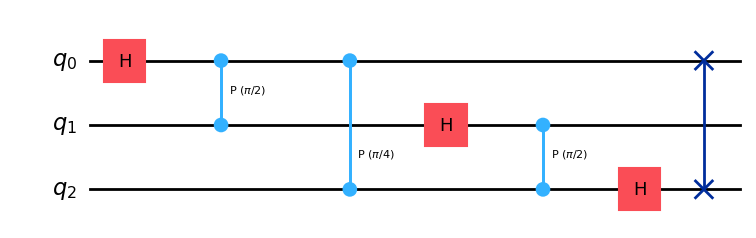

In [2]:
def qft_3qubit():
    qc = QuantumCircuit(3)
    qc.h(0)
    qc.cp(np.pi/2, 1, 0)
    qc.cp(np.pi/4, 2, 0)
    qc.h(1)
    qc.cp(np.pi/2, 2, 1)
    qc.h(2)
    # Swap qubits to reverse order
    qc.swap(0, 2)
    return qc

qc_qft = qft_3qubit()
qc_qft.draw('mpl')


IQFT

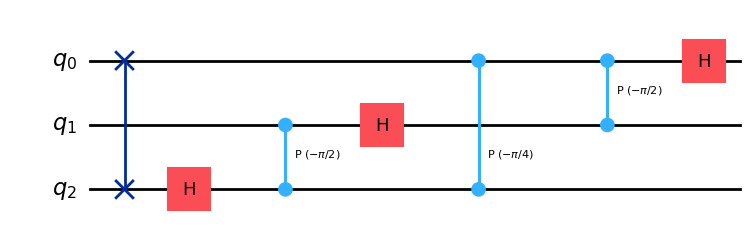

In [3]:
def iqft_3qubit():
    qc = QuantumCircuit(3)
    # Swap qubits to reverse order
    qc.swap(0, 2)
    qc.h(2)
    qc.cp(-np.pi/2, 2, 1)
    qc.h(1)
    qc.cp(-np.pi/4, 2, 0)
    qc.cp(-np.pi/2, 1, 0)
    qc.h(0)
    return qc

qc_iqft = iqft_3qubit()
qc_iqft.draw('mpl')


Phase Estimation Algorithm

Estimating the phase for U = Z (Pauli-Z), eigenvector |1⟩ (phase = 1/2):

Phase Estimation Result: {'011': 438, '101': 434, '001': 74, '111': 78}


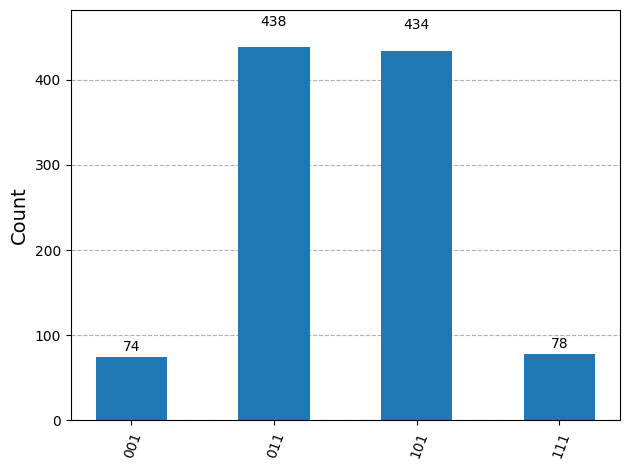

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

n_count = 3

qc = QuantumCircuit(n_count + 1, n_count)

qc.x(n_count)

qc.h(0)
qc.h(1)
qc.h(2)

# Apply controlled-U^2^j gates (U = Z)
qc.cz(0, n_count)
qc.cz(1, n_count)
qc.cz(2, n_count)

# Apply inverse QFT to counting qubits
def iqft_on(qc, qubits):
    n = len(qubits)
    for i in range(n//2):
        qc.swap(qubits[i], qubits[n-i-1])
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), qubits[j], qubits[m])
        qc.h(qubits[j])

iqft_on(qc, [0, 1, 2])

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

sim = AerSimulator()
tqc = transpile(qc, sim)
job = sim.run(tqc, shots=1024)
counts = job.result().get_counts()
print("Phase Estimation Result:", counts)
plot_histogram(counts)


Shor's Algorithm:

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import UnitaryGate
from math import gcd
from fractions import Fraction
import numpy as np

def c_amodN(qc, a, N, power, ctrl, target):
    n = len(target)
    dim = 2 ** n
    U = np.zeros((dim, dim))
    for x in range(dim):
        if x < N:
            y = (pow(a, power, N) * x) % N
        else:
            y = x
        U[y, x] = 1
    modmult_gate = UnitaryGate(U, label=f"{a}^{power}%{N}")
    cmodmult_gate = modmult_gate.control(1)
    qc.append(cmodmult_gate, [ctrl] + target)
    return qc

def inverse_qft(qc, qubits):
    n = len(qubits)
    for i in range(n//2):
        qc.swap(qubits[i], qubits[n-i-1])
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), qubits[j], qubits[m])
        qc.h(qubits[j])

def shor(N, n_count=None, shots=1024, verbose=True):
    n_mod = N.bit_length()
    if n_count is None:
        n_count = 2 * n_mod

    # Loop over all a in [2, N-1] that are coprime to N
    for a in range(2, N):
        if gcd(a, N) != 1:
            continue
        if verbose:
            print(f"\nTrying a = {a}")

        qc = QuantumCircuit(n_count + n_mod, n_count)

        # Superposition on counting register
        for q in range(n_count):
            qc.h(q)
        # Initialize modular register to |1>
        qc.x(n_count)

        # Controlled modular exponentiation
        for q in range(n_count):
            c_amodN(qc, a, N, 2**q, q, list(range(n_count, n_count + n_mod)))

        # Inverse QFT
        inverse_qft(qc, list(range(n_count)))

        # Measure counting register
        for q in range(n_count):
            qc.measure(q, q)

        # Simulate
        sim = AerSimulator()
        tqc = transpile(qc, sim)
        job = sim.run(tqc, shots=shots)
        counts = job.result().get_counts()
        measured = max(counts, key=counts.get)
        phase_decimal = int(measured, 2) / 2**n_count
        frac = Fraction(phase_decimal).limit_denominator(N)
        r = frac.denominator

        if verbose:
            print(f"Measured: {measured} (phase={phase_decimal}, r={r})")

        # Classical post-processing
        if r % 2 == 0 and pow(a, r//2, N) != N-1:
            plus = pow(a, r//2, N) + 1
            minus = pow(a, r//2, N) - 1
            factor1 = gcd(plus, N)
            factor2 = gcd(minus, N)
            if factor1 not in [1, N] and factor2 not in [1, N]:
                print(f"\nNon-trivial factors of {N} are: {factor1} and {factor2}")
                return factor1, factor2, a
    print("No non-trivial factors found for any coprime a.")
    return None

Running Shor's on different values of N:

In [8]:
shor(21)


Trying a = 2
Measured: 0000000000 (phase=0.0, r=1)

Trying a = 4
Measured: 0000000000 (phase=0.0, r=1)

Trying a = 5
Measured: 1000000000 (phase=0.5, r=2)

Trying a = 8
Measured: 1000000000 (phase=0.5, r=2)

Non-trivial factors of 21 are: 3 and 7


(3, 7, 8)

In [7]:
shor(15)


Trying a = 2
Measured: 10000000 (phase=0.5, r=2)

Trying a = 4
Measured: 00000000 (phase=0.0, r=1)

Trying a = 7
Measured: 00000000 (phase=0.0, r=1)

Trying a = 8
Measured: 00000000 (phase=0.0, r=1)

Trying a = 11
Measured: 10000000 (phase=0.5, r=2)

Non-trivial factors of 15 are: 3 and 5


(3, 5, 11)